Main Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB
None

Extra Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10384 entries, 0 to 10383
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   InstanceID   10384 non-null  int64 
 1   patientID    10384 non-null  int64 
 2   ImageName    10384 non-null  object
 3   isCancerous  10384 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 324.6+ KB
None

Main Data Sample:
   InstanceID  patientI

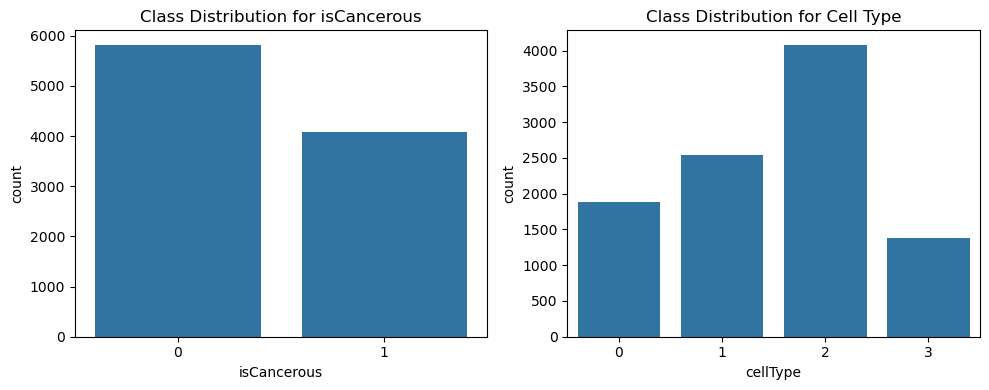

Displaying sample images from the dataset:


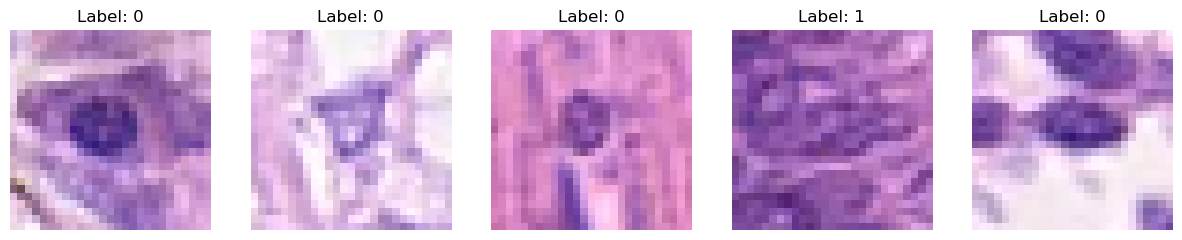

Training Data Size: 7916
Validation Data Size: 1980
Models created successfully!


c:\Users\kumar\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Found 7916 validated image filenames belonging to 2 classes.
Found 7916 validated image filenames belonging to 4 classes.
Training Generators created successfully!


In [2]:
""# Colon Cancer Image Classification Project
# Step 1: Data Loading and Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

# Paths to CSV files and Image folder
MAIN_DATA_CSV = 'data_labels_mainData.csv'
EXTRA_DATA_CSV = 'data_labels_extraData.csv'
IMAGE_FOLDER = 'patch_images/'

# Load CSV data
main_data = pd.read_csv(MAIN_DATA_CSV)
extra_data = pd.read_csv(EXTRA_DATA_CSV)

# Display basic info
print('Main Data Information:')
print(main_data.info())
print('\nExtra Data Information:')
print(extra_data.info())

# Display first few rows
print('\nMain Data Sample:')
print(main_data.head())
print('\nExtra Data Sample:')
print(extra_data.head())

# Check class distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.countplot(x='isCancerous', data=main_data)
plt.title('Class Distribution for isCancerous')
plt.subplot(1, 2, 2)
sns.countplot(x='cellType', data=main_data)
plt.title('Class Distribution for Cell Type')
plt.tight_layout()
plt.show()

# Function to load and display a few images
def display_sample_images(df, image_folder, num_samples=5):
    samples = df.sample(num_samples)
    plt.figure(figsize=(15, 3))
    for idx, row in enumerate(samples.iterrows()):
        img_path = os.path.join(image_folder, row[1]['ImageName'])
        img = Image.open(img_path)
        plt.subplot(1, num_samples, idx + 1)
        plt.imshow(img)
        plt.title(f"Label: {row[1]['isCancerous']}")
        plt.axis('off')
    plt.show()

# Display some sample images
print("Displaying sample images from the dataset:")
display_sample_images(main_data, IMAGE_FOLDER)

# -------------------------------
# Step 2: Data Preprocessing
# -------------------------------
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Data Generator for Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Splitting the data for training and validation
train_data, val_data = train_test_split(main_data, test_size=0.2, stratify=main_data['isCancerous'], random_state=42)

print(f"Training Data Size: {len(train_data)}")
print(f"Validation Data Size: {len(val_data)}")

# -------------------------------
# Step 3: Model Selection and Training
# -------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Input Image Dimensions
IMG_HEIGHT = 27
IMG_WIDTH = 27
IMG_CHANNELS = 3

# Model 1: CNN for isCancerous Classification
model_cancer_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cancer_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model 2: CNN for Cell Type Classification
model_celltype_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

model_celltype_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Models created successfully!")

# -------------------------------
# Step 4: Training and Validation
# -------------------------------

# Define training generators
train_data['isCancerous'] = train_data['isCancerous'].astype(str)
val_data['isCancerous'] = val_data['isCancerous'].astype(str)
train_data['cellType'] = train_data['cellType'].astype(str)
val_data['cellType'] = val_data['cellType'].astype(str)

train_generator_cancer = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='binary'
)

train_generator_celltype = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=IMAGE_FOLDER,
    x_col='ImageName',
    y_col='cellType',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse'
)

print("Training Generators created successfully!")

